# Final Project: Task 2 - Biodiversity Intactness Index Change in Phoenix, AZ

# **About**

**Purpose:** Analyze the effects of urban expansion on biodiversity in Phoenix, Arizona.

**GitHub Link**

[https://github.com/zachyyy700/eds220-phoenix-biodiversity]()

**Highlights:**

- `rioxarray` raster operations
- Spatiotemporal Asset Catalog (`STAC`) data search
- Microsoft Planetary Computer (MPC) STAC API interaction

**Data:** 
- Biodiversity Intactness Index (BII) Time Series: From the io-biodiversity collection from the Microsoft Planetary Computer STAC. For data access, follow API interaction steps listed under "Example Notebook" at [https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview]().
- Arizona Shapefiles: From the Arizona counties polygon provided by the US Census Bureau. Data accessed through downloading the .zip file from [https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision]().

**References**

F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: [https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf]()

U.S. Census Bureau. (2024). TIGER/Line Shapefile, Current, State, Arizona, County Subdivision. Retrieved from [https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision]()

# Analysis

## Load packages

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import planetary_computer
from pystac_client import Client
import contextily as ctx
from matplotlib.lines import Line2D

## Load and explore data

In [6]:
# Read Arizona shapefile
path = os.path.join('data', 'tl_2024_04_cousub', 'tl_2024_04_cousub.shp')
arizona = gpd.read_file(path)

In [7]:
phoenix = arizona[arizona['NAME'] == "Phoenix"]
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

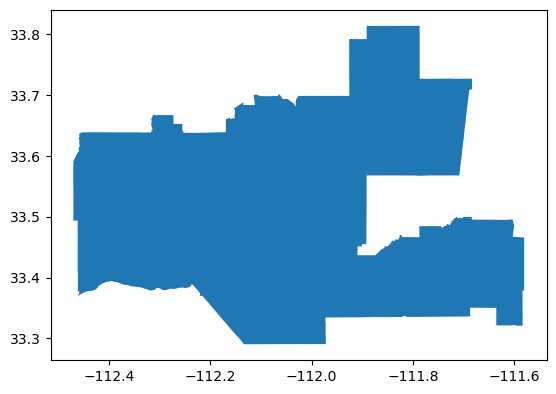

In [8]:
phoenix.plot()

To load the BII data, parameters can be set like `bbox` and `dates` which is passed in the `.search()` method. This will narrow our search within the STAC API so we only receive data of specified interest.

In [9]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set search parameters
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
dates = "2017-01-01/2021-01-01"

# Search MPC catalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=dates)
items = search.item_collection()

In [10]:
# Print the datatimes of received items
for item in items:
    print(item.properties['start_datetime'])

2020-01-01T00:00:00Z
2019-01-01T00:00:00Z
2018-01-01T00:00:00Z
2017-01-01T00:00:00Z


In [11]:
# Load the items data into DataArrays
biodiv_2017 = rioxr.open_rasterio(items[3].assets["data"].href)
biodiv_2020 = rioxr.open_rasterio(items[0].assets["data"].href)

In [14]:
print(f"Current CRS:\n{biodiv_2017.spatial_ref.crs_wkt}\n")
print(f"Data Bounds:\n{biodiv_2017.rio.bounds()}")

Current CRS:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Data Bounds:
(-115.38597824385106, 27.56531399453427, -108.20664249316783, 34.74464974521749)


Before further analysis, the Coordinate Reference System (CRS) must match for each of these geospatial data.

In [15]:
biodiv_2017 = biodiv_2017.rio.write_crs(biodiv_2017.spatial_ref.crs_wkt)
print(biodiv_2017.rio.crs)

EPSG:4326


In [16]:
phoenix = phoenix.to_crs("EPSG:4326")
print(phoenix.crs)

EPSG:4326


## Phoenix subdivision

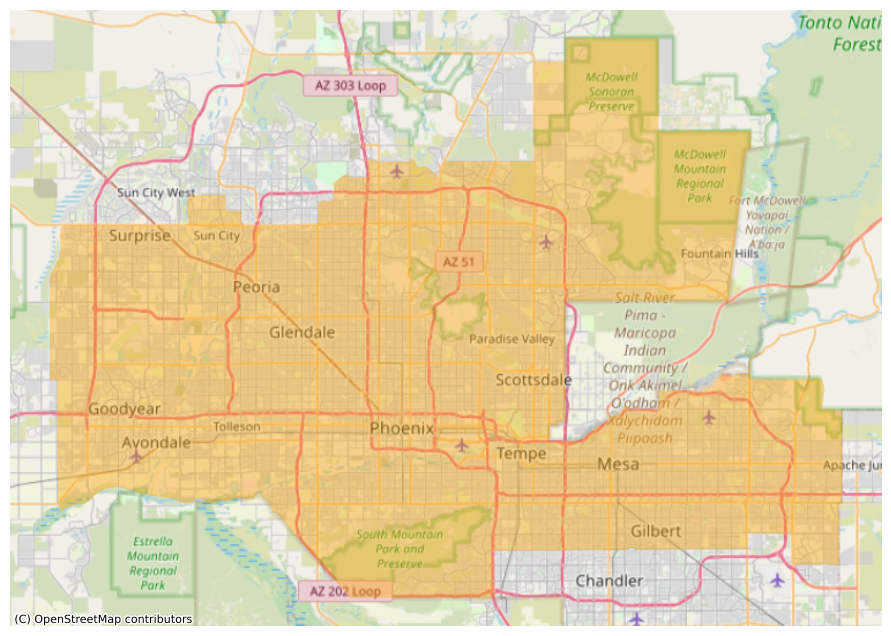

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))

phoenix.plot(ax=ax, alpha=0.4, color='orange')

ax.axis('off')

# Add basemap using contextily
ctx.add_basemap(ax, crs=phoenix.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

In [18]:
# Clip biodiversity data to Phoenix total bounds, then to the subdivision geometry
biodiv_2017_clip = biodiv_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
biodiv_2020_clip = biodiv_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)

## BII Percentage Comparison

In [19]:
# Calculate percentages of high BII for 2017 & 2020
high_bii_2017 = biodiv_2017_clip >= 0.75
pct_2017 = (high_bii_2017.sum() / biodiv_2017_clip.count()) * 100

high_bii_2020 = biodiv_2020_clip >= 0.75
pct_2020 = (high_bii_2020.sum() / biodiv_2020_clip.count()) * 100

print(f"High BII Percentage in 2017: {pct_2017.values:.2f}%")
print(f"High BII Percentage in 2020: {pct_2020.values:.2f}%")

High BII Percentage in 2017: 7.13%
High BII Percentage in 2020: 6.49%


## Visualize BII Change

Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.

- Right now in high_bii_2017 & high_bii_2020 arrays, cells are `True` if BII >= 0.75.
- We want cells where high_bii_2017 == `True` *and* high_bii_2020 == `False`
- Using `~` on `high_bii_2020`, boolean values are inverted
- Combined with the `&` operator, the resulting DataArray is True where cells meet both conditions, indicating a drop in BII from 2017 to 2020

`xr.DataArray.where()`

Filter elements from this object according to a condition.

Returns elements from ‘DataArray’, where ‘cond’ is True, otherwise fill in ‘other’ (NA by default).

In [20]:
bii_loss = high_bii_2017 & (~high_bii_2020)

# Assign 0 to nan
bii_loss_masked = bii_loss.where(bii_loss != 0)

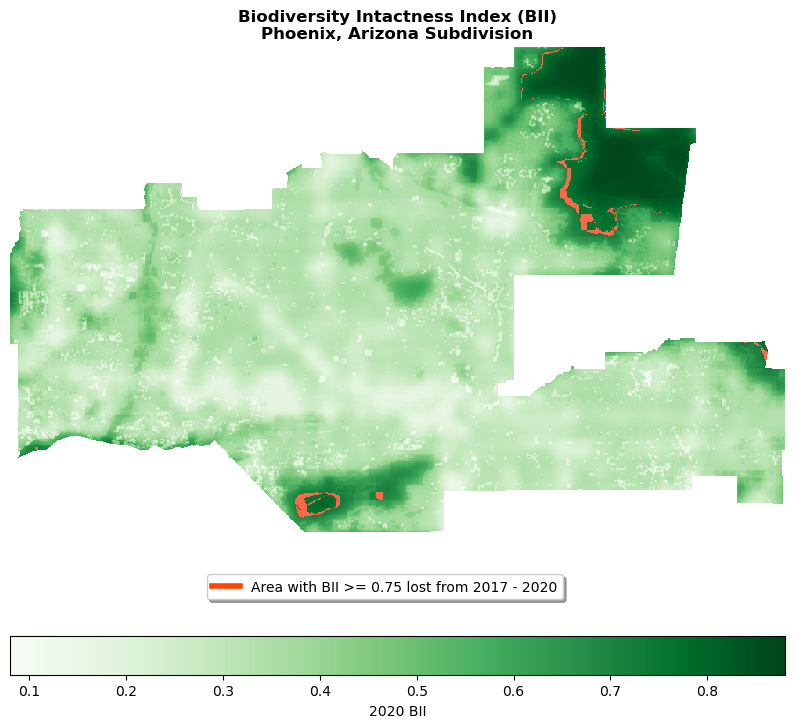

In [22]:
fig, ax = plt.subplots(figsize=(10, 9)) 

ax.axis('off')

biodiv_2020_clip.plot(ax=ax, cmap="Greens", cbar_kwargs={'location':'bottom', 'label':'2020 BII'})
bii_loss_masked.plot(ax=ax, cmap='Reds', 
                     add_colorbar=False)

# Custom legend
custom_line = [Line2D([0], [0], color='orangered', lw=4)]
fig.legend(custom_line, ['Area with BII >= 0.75 lost from 2017 - 2020'], bbox_to_anchor=(0.5, 0.28), loc='center', fontsize=10, shadow=True)

plt.title("Biodiversity Intactness Index (BII)\nPhoenix, Arizona Subdivision", weight='bold')
plt.show()

In this final plot, 2020 BII values of the Phoenix area are plotted along a green color scale, where darker greens indicate higher BII. In addition, areas with high BII that were lost from 2017 to 2020 are highlighted in an orange-red color. Two notable areas are around the South Mountain Park and Reserve (bottom) and the McDowell Mountain Regional Park (top right). These are areas with high BII indicated by the dark green but they also contain significant areas of BII loss, likely due to Phoenix's urban expansion.